## Dataset Link : 
https://drive.google.com/drive/folders/1s7LQEJag6MiHTUmE4Db-yA7pRg51J1YZ?usp=sharing

In [1]:
import os
import random
import shutil
import pickle

import numpy as np

import PIL

import matplotlib.pyplot as plt

import torchvision
import torchvision.utils
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler

from functorch import vmap
from functools import partial

from typing import Tuple, Iterable


In [2]:
### Helper Functions

# Showing images
def imshow(img, text=None):
    
    npimg = img.numpy()
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.axis("off")
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

# Plotting losses
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

# plotting loss vs accuracies
def show_la_plot(loss_list,  accuracy_list, title = "Loss vs Accuracy"):
    
    fig, ax1 = plt.subplots()

    color = 'tab:green'
    ax1.set_xlabel('epoch',color=color)
    
    color = 'tab:red'
    ax1.plot(loss_list,color=color)
    ax1.set_ylabel('total loss',color=color)
    ax1.tick_params(axis='y', color=color)
        
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)  
    ax2.plot( accuracy_list, color=color)
    ax2.tick_params(axis='y', color=color)

    ax1.set_title(title)

    fig.tight_layout()

    plt.show()
    
    
# visualizing data    
def visualize_images(pair_dataset, num_pairs):
    
    print("\n\nvisualising ", num_pairs, " data samples from the dataset\n")
    
    # Create a simple dataloader just for simple visualization
    vis_dataloader = DataLoader(pair_dataset, shuffle=True, batch_size=num_pairs)

    # Extract one batch
    example_batch = next(iter(vis_dataloader))

    concatenated = torch.cat((example_batch[0], example_batch[1]),0)

    imshow(torchvision.utils.make_grid(concatenated, nrow=num_pairs))
    
        
    
# computing the accuracy
def compute_accuracy(model, data_loader):
    
    correct = 0
    total = 0

    for img_q, img_s, true_label, _ in data_loader:
        
        # if there are more than three classes of data (it might happen if we use some additional dataset like cifar 
        # for the not related class), labeling all the extra classes as 2 (not related)
        true_label = torch.where(true_label > 2, torch.tensor([2]), true_label)
        
        similarity, logits = model(img_q, img_s)
        
        logits = torch.softmax(logits, dim=1)
        
        predicted_label = torch.argmax(logits, dim=-1)
        
        correct += (predicted_label == true_label).sum().item()
        total += true_label.size(0)
    
    accuracy = correct / total
    
    return accuracy


In [3]:
# creates a random pair from the dataset, because our siamese model expects a pair of data at the same time
# here one is query image, and another one is the support image

class PairDataset(Dataset):
    
    def __init__(self,dataset,transform=None,should_invert=True):
        self.dataset = dataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
                
        data0 = random.choice(self.dataset)

        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0, 1)
        
        if should_get_same_class:
            #keep looping till the same class image is found
            while True:
                data1 = random.choice(self.dataset)
                if data0[1] == data1[1]:
                    break
                    
        else:
            data1 = random.choice(self.dataset)

                    
        img0 = PIL.Image.fromarray(data0[0])
        img0_label = data0[1]
        
        img1 = PIL.Image.fromarray(data1[0])
        img1_label = data1[1]
            
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1, img0_label, img1_label
        
    
    def __len__(self):
        return len(self.dataset)

In [4]:
# creating a triplet from the dataset, because we are using triplet loss, which requires 3 images
# here, one is anchor image 
# another one is positive image, which is from the same class as anchor
# and another one is negative image, which is from a different class from anchor

class TripletDataset(Dataset):
    
    def __init__(self,dataset,transform=None,should_invert=True):
        self.dataset = dataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
                
        data0 = random.choice(self.dataset)
        
        #keep looping till the same class image is found
        while True:
            data1 = random.choice(self.dataset)
            if data0[1] == data1[1]:
                break
        
        #keep looping till a different class image is found
        while True:
            data2= random.choice(self.dataset)
            if data0[1] != data2[1]:
                break
       
                    
        img_anch = PIL.Image.fromarray(data0[0])
        img_pos = PIL.Image.fromarray(data1[0])
        img_neg = PIL.Image.fromarray(data2[0])
            
        if self.should_invert:
            img_anch = PIL.ImageOps.invert(img_anch)
            img_pos = PIL.ImageOps.invert(img_pos)
            img_neg = PIL.ImageOps.invert(img_neg)

        if self.transform is not None:
            img_anch = self.transform(img_anch)
            img_pos = self.transform(img_pos)
            img_neg = self.transform(img_neg)

        img_anch_label = data0[1]
        
        return img_anch, img_pos, img_neg, img_anch_label
        
    
    def __len__(self):
        return len(self.dataset)

In [5]:
# given the anchor-positive similarity, and anchor-negative similarity, computes triplet loss

class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, similarity_pos, similarity_neg):
        
        losses = torch.relu(similarity_pos - similarity_neg + self.margin)
        
        return losses.mean()

In [6]:
# Siamese Model

class SiameseNetwork(nn.Module):
    def __init__(self, cnn_layers: Iterable, linear_layers):
        super().__init__()
        
        # pass in a NN
        self.cnn_layers = nn.Sequential(*cnn_layers)
        self.linear_layers = nn.Sequential(*linear_layers)
        
    
    def forward(self, x_query: torch.Tensor, x_support: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Forward Pass:
            arg: Query Image (any image)
                 Support Image
        
        """
        
        x_query = self.cnn_layers(x_query)        
        x_support = self.cnn_layers(x_support)
        
        # similarity between query and support images. will be used for triplet loss
        similarity = vmap(F.pairwise_distance)(x_query, x_support)[:, None]        

        # logits for query image. will be used for cross entropy loss
        logits = self.linear_layers(x_query.view(x_query.size()[0], -1))
            
        return similarity, logits


In [7]:
# network layers for model

out_channes = 2

cnn_layers = [
    
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(16),
    nn.MaxPool2d(kernel_size=2),
    
    nn.Conv2d(16, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(kernel_size=2),

    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(kernel_size=2),
]

linear_layers = [
    
    nn.Linear(64 * 3 * 3, 128),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Linear(128, out_channes)
]



In [8]:
# Hyperparametes 

batch_size = 128
learning_rate = 0.01
weight_decay = 0.005
epochs = 30


In [9]:
# model save path

save_model_path = 'saved_models/accident_best_model.pth'


In [10]:
# Loading the data

root = "datasets_for_comparison"

with open(root+'/accident_detection_train.pkl', 'rb') as f:
    train_set = pickle.load(f)
with open(root+'/accident_detection_validation.pkl', 'rb') as f:
    validation_set = pickle.load(f)
with open(root+'/accident_detection_test.pkl', 'rb') as f:
    test_set = pickle.load(f)
    
print("Train Data Size       = ", len(train_set))
print("Validation Data Size  = ", len(validation_set))
print("Test Data Size  = ", len(test_set))


Train Data Size       =  2938
Validation Data Size  =  979
Test Data Size  =  981




visualising  10  data samples from the dataset



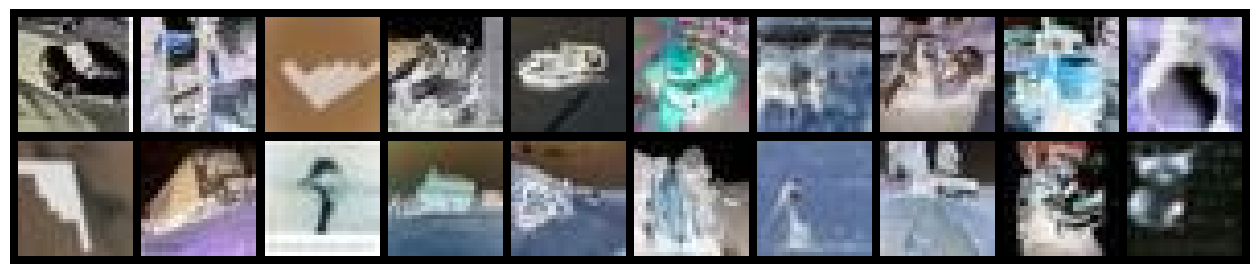



Batch Size    =  128
Train Batches =  23
Validation Batches  =  8




In [11]:

## Loading Data


transformation = transforms.Compose([transforms.Resize((28, 28)),
                                     transforms.ToTensor(),
                                    ])


# Load the training dataset

train_dataset = TripletDataset(train_set, transform=transformation)
validation_dataset = PairDataset(validation_set, transform=transformation)

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
validation_loader = DataLoader(validation_dataset, shuffle=True, batch_size=batch_size)

visualize_images(validation_dataset, num_pairs=10)

print("\n")
print("Batch Size    = ", batch_size)
print("Train Batches = ", len(train_loader))
print("Validation Batches  = ", len(validation_loader))
print("\n")


In [12]:
# Training

model = SiameseNetwork(cnn_layers, linear_layers)

crossentropy = nn.CrossEntropyLoss()
triplet = TripletLoss(margin=1)

optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay = weight_decay)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

loss_history = [] 
acc_history = [] 

mx_acc = -1

for epoch in range(epochs):

    tot_loss = 0

    for i, (img_a, img_p, img_n, q_label) in enumerate(train_loader, 0):

        similarity_p, logits_a = model.forward(img_a, img_p)
        similarity_n, logits_a = model.forward(img_a, img_n)

        # if there are more than three classes of data (it might happen if we use some additional dataset like cifar 
        # for the not related class), labeling all the extra classes as 2 (not related)
        q_label = torch.where(q_label > 2, torch.tensor([2]), q_label)

        loss = triplet(similarity_p, similarity_n) + crossentropy(logits_a, q_label)

        tot_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
#         scheduler.step(loss)
        
    # average loss for this epoch
    tot_loss /= len(train_loader)
    
    # accuracy on validation set
    accuracy = compute_accuracy(model, validation_loader)
    
    # saving the best model
    if(accuracy > mx_acc):
        mx_acc = accuracy
        torch.save(model, save_model_path)
    
    loss_history.append(tot_loss)
    acc_history.append(accuracy)

    print(f"Epoch {epoch} :: Curr Loss = {tot_loss:.5f}  :: Curr Acc = {accuracy:.5f}")



Epoch 0 :: Curr Loss = 1.41954  :: Curr Acc = 0.83759
Epoch 1 :: Curr Loss = 0.85697  :: Curr Acc = 0.90296
Epoch 2 :: Curr Loss = 0.71335  :: Curr Acc = 0.92748
Epoch 3 :: Curr Loss = 0.66260  :: Curr Acc = 0.92441
Epoch 4 :: Curr Loss = 0.62205  :: Curr Acc = 0.91318
Epoch 5 :: Curr Loss = 0.61601  :: Curr Acc = 0.90501
Epoch 6 :: Curr Loss = 0.62074  :: Curr Acc = 0.92646
Epoch 7 :: Curr Loss = 0.49500  :: Curr Acc = 0.88355
Epoch 8 :: Curr Loss = 0.53808  :: Curr Acc = 0.92952
Epoch 9 :: Curr Loss = 0.50070  :: Curr Acc = 0.91011
Epoch 10 :: Curr Loss = 0.52244  :: Curr Acc = 0.92441
Epoch 11 :: Curr Loss = 0.44244  :: Curr Acc = 0.92850
Epoch 12 :: Curr Loss = 0.53314  :: Curr Acc = 0.91624
Epoch 13 :: Curr Loss = 0.47426  :: Curr Acc = 0.92952
Epoch 14 :: Curr Loss = 0.46573  :: Curr Acc = 0.92033
Epoch 15 :: Curr Loss = 0.46601  :: Curr Acc = 0.92543
Epoch 16 :: Curr Loss = 0.46364  :: Curr Acc = 0.92339
Epoch 17 :: Curr Loss = 0.43123  :: Curr Acc = 0.93871
Epoch 18 :: Curr Los

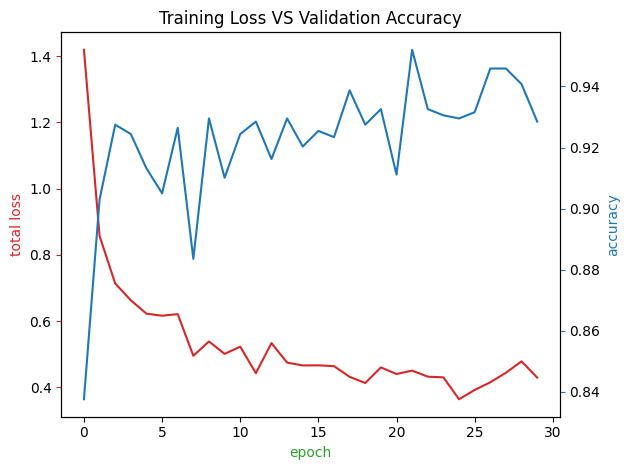

In [13]:
show_la_plot(loss_history, acc_history, title="Training Loss VS Validation Accuracy")

In [14]:
## Testing

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

test_dataset = PairDataset(test_set, transform=transformation)
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)

model = torch.load(save_model_path)

true_labels = []
predicted_labels = []

for img_q, img_s, true_label, _ in test_loader:
                
        similarity, logits = model(img_q, img_s)
        
        logits = torch.softmax(logits, dim=1)
        
        predicted_label = torch.argmax(logits, dim=-1)
        
        true_labels.extend(true_label.numpy())
        predicted_labels.extend(predicted_label.numpy())


precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')
accuracy = accuracy_score(true_labels, predicted_labels)

print("\nOn Test Data\n")
print("Precision : ", precision)
print("Recall    : ", recall)
print("F1-score  : ", f1)
print("Accuracy  : ", accuracy)
print("\n\n")


On Test Data

Precision :  0.9551473888972019
Recall    :  0.9551473888972019
F1-score  :  0.9551473888972017
Accuracy  :  0.9551478083588175



